# Classification of Pnemonia Cases using PneumoniaMNIST

In [1]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from torchvision.transforms import transforms

In [15]:
train_data = medmnist.PneumoniaMNIST(split='train', download=True, transform=transforms.ToTensor())
val_data = medmnist.PneumoniaMNIST(split='val', download=True, transform=transforms.ToTensor())
test_data = medmnist.PneumoniaMNIST(split='test', download=True, transform=transforms.ToTensor())

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


Visual Data Analysis

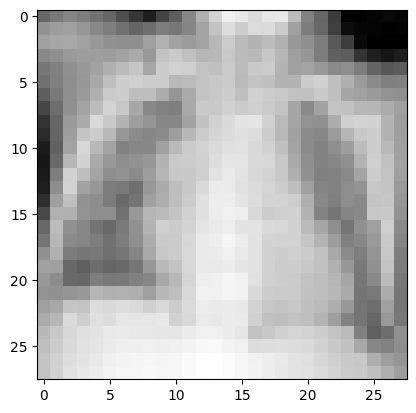

In [16]:
for img, t in train_data:

  img = img.numpy()
  img = img.transpose(1, 2, 0)
  plt.imshow(img, cmap='gray')
  break

Analysing images with and without pneumonia

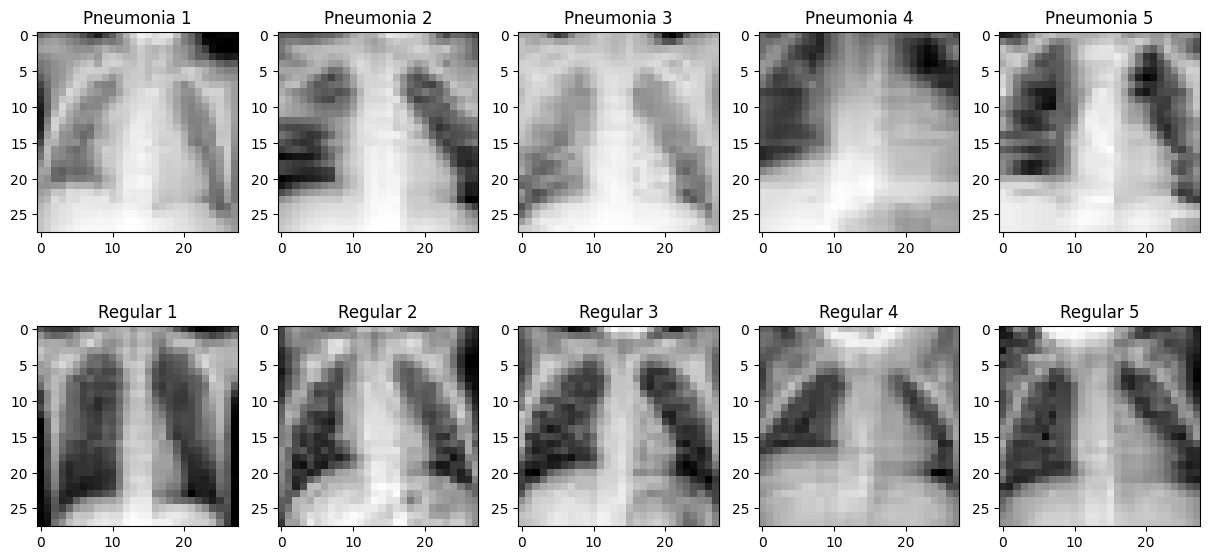

In [20]:
p_images = [] # pneumonia images
r_images = [] # regular images

for img, t in train_data:
  if t == 1 and len(p_images) < 5:
    p_images.append(img)
  elif t == 0 and len(r_images) < 5:
    r_images.append(img)

  if len(p_images) == 5 and len(r_images) == 5:
    break

# display the images in subplots using plt

fig, axs = plt.subplots(2, 5, figsize=(15, 7))

for i in range(5):
  axs[0, i].imshow(p_images[i].numpy().transpose(1, 2, 0), cmap='gray')
  axs[0, i].set_title(f'Pneumonia {i+1}')
  axs[1, i].imshow(r_images[i].numpy().transpose(1, 2, 0), cmap='gray')
  axs[1, i].set_title(f'Regular {i+1}')

# plt.tight_layout()

plt.show()

In [18]:
print(len(train_data), len(val_data), len(test_data))

4708 524 624


# Multi Layer Perceptron Model

In [32]:
from torch import nn

class MLP(nn.Module):

  def __init__(self, input_size=28*28, hidden_size=100, output_size=1):

    super(MLP, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.linear_1 = nn.Linear(input_size, hidden_size)
    self.linear_2 = nn.Linear(hidden_size, hidden_size)
    self.linear_3 = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()

  def forward(self, x):
    temp = self.linear_1(x)
    temp = self.relu(temp)
    temp = self.linear_2(temp)
    temp = self.relu(temp)
    temp = self.linear_3(temp)
    return temp


In [56]:
from torch.utils.data import DataLoader
import torch

def accuracy(model, data):
  total, correct = 0, 0

  for img, t in DataLoader(data, batch_size=100):
    img = img.reshape(-1, model.input_size)
    z = model(img)
    y = torch.where(z > 0.5, torch.tensor(1), torch.tensor(0))

    correct += int(torch.sum(t == y))

    total += t.shape[0]

  return correct / total




In [69]:
from tqdm import tqdm

def train_model(model, train_data, val_data, epochs=10, alpha=0.05, plot_every=50):
  """
  Trains the model with the available data.
  """

  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

  iter = 0
  iters, train_loss, train_acc, val_acc = [], [], [], []

  try:
    for epoch in range(epochs):
      for img, t in tqdm(DataLoader(train_data, batch_size=100, shuffle=True)):

        img = img.reshape(-1, model.input_size)
        z = model(img)

        loss = criterion(z, t.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iter += 1

        if iter % plot_every == 0:
          iters.append(iter)
          train_loss.append(float(loss))
          train_acc.append(accuracy(model, train_data))
          val_acc.append(accuracy(model, val_data))

  finally:

    print(f'Training Accuracy: {train_acc[-1]} \n Validation Accuracy: {val_acc[-1]}')

    plt.figure(figsize=(10, 5))
    plt.plot(iters, train_loss, label='Train Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.title("Training Loss")

    plt.figure(figsize=(10, 5))
    plt.plot(iters, train_acc, label='Train Accuracy')
    plt.plot(iters, val_acc, label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")

    plt.show()

  return iters, train_loss, train_acc, val_acc





100%|██████████| 48/48 [00:00<00:00, 49.03it/s]


Training Accuracy: 0.9320305862361937 
 Validation Accuracy: 0.9446564885496184


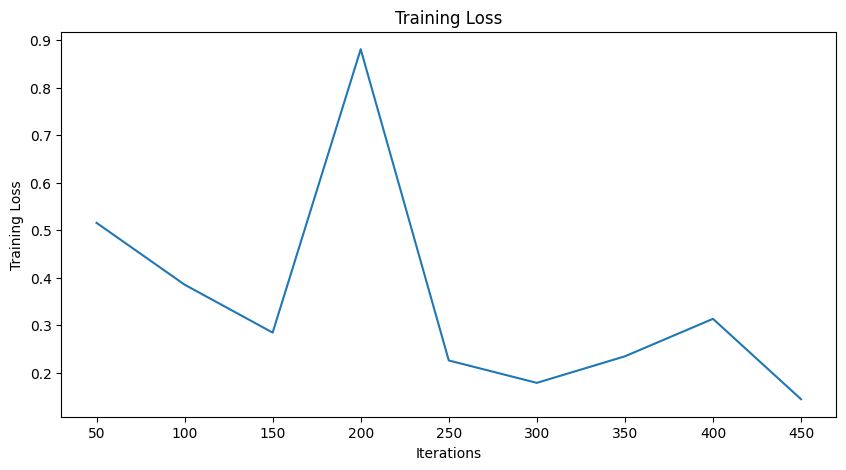

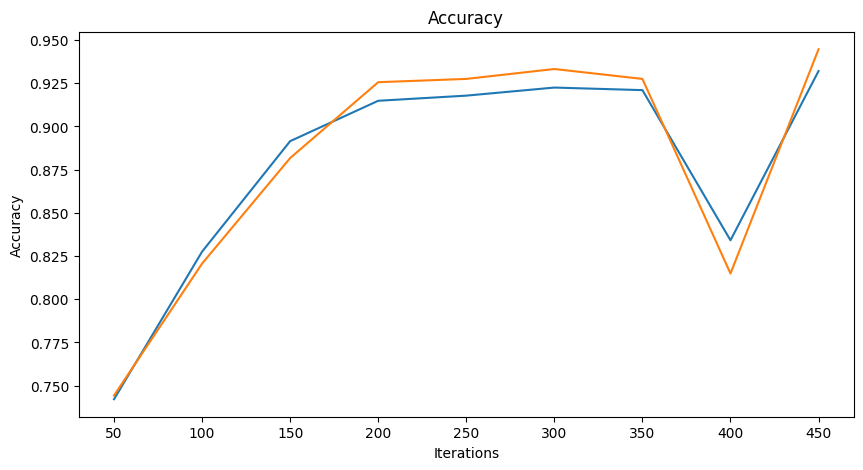

In [70]:
model_1 = MLP(28*28, 100, 1)
mlp_metrics_1 = train_model(model_1, train_data, val_data)


100%|██████████| 48/48 [00:00<00:00, 48.45it/s]


Training Accuracy: 0.8899745114698385 
 Validation Accuracy: 0.8778625954198473


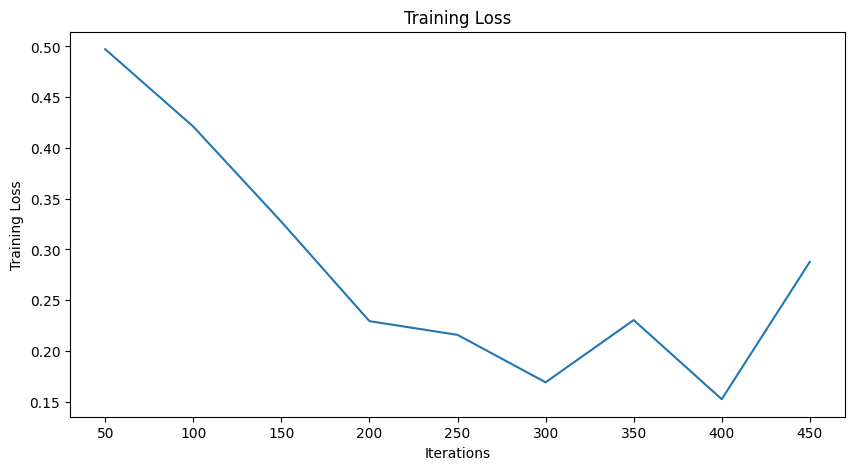

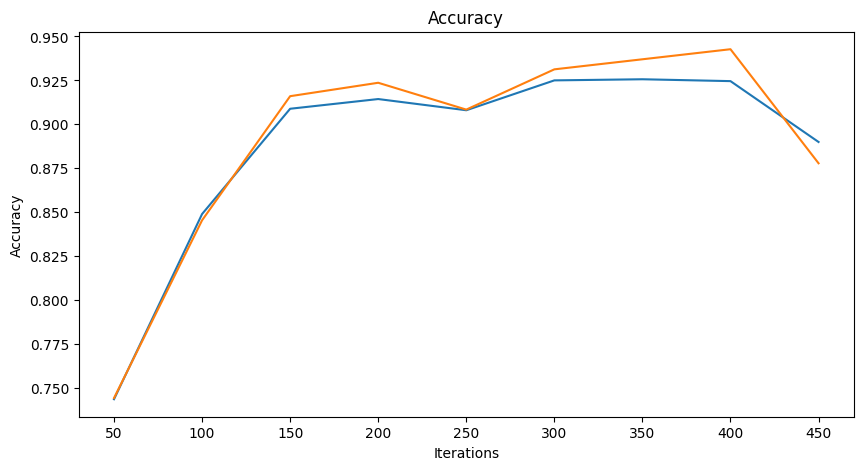

In [71]:
model_2 = MLP(28*28, 150, 1)
mlp_metrics_2 = train_model(model_2, train_data, val_data)

100%|██████████| 48/48 [00:01<00:00, 45.73it/s]


Training Accuracy: 0.9256584536958369 
 Validation Accuracy: 0.9427480916030534


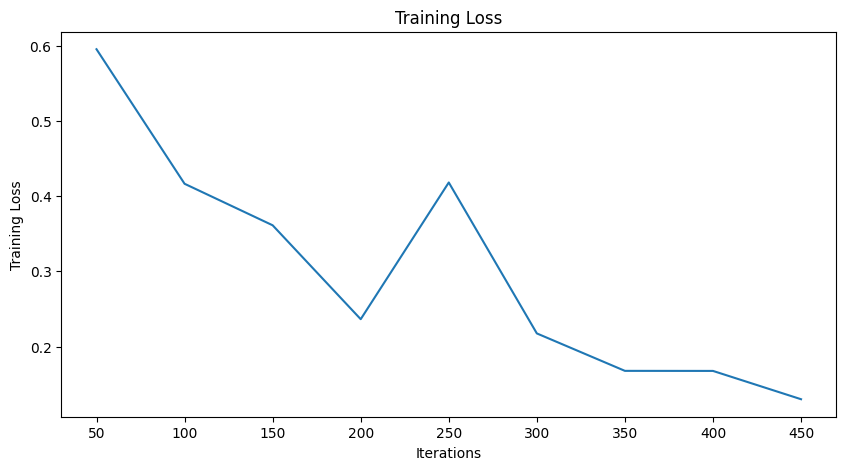

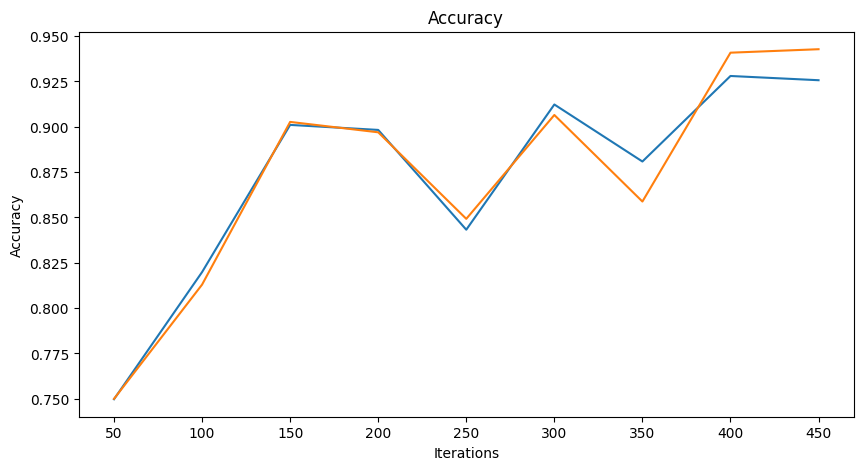

In [84]:
model_3 = MLP(28*28, 200, 1)
mlp_metrics_3 = train_model(model_3, train_data, val_data)

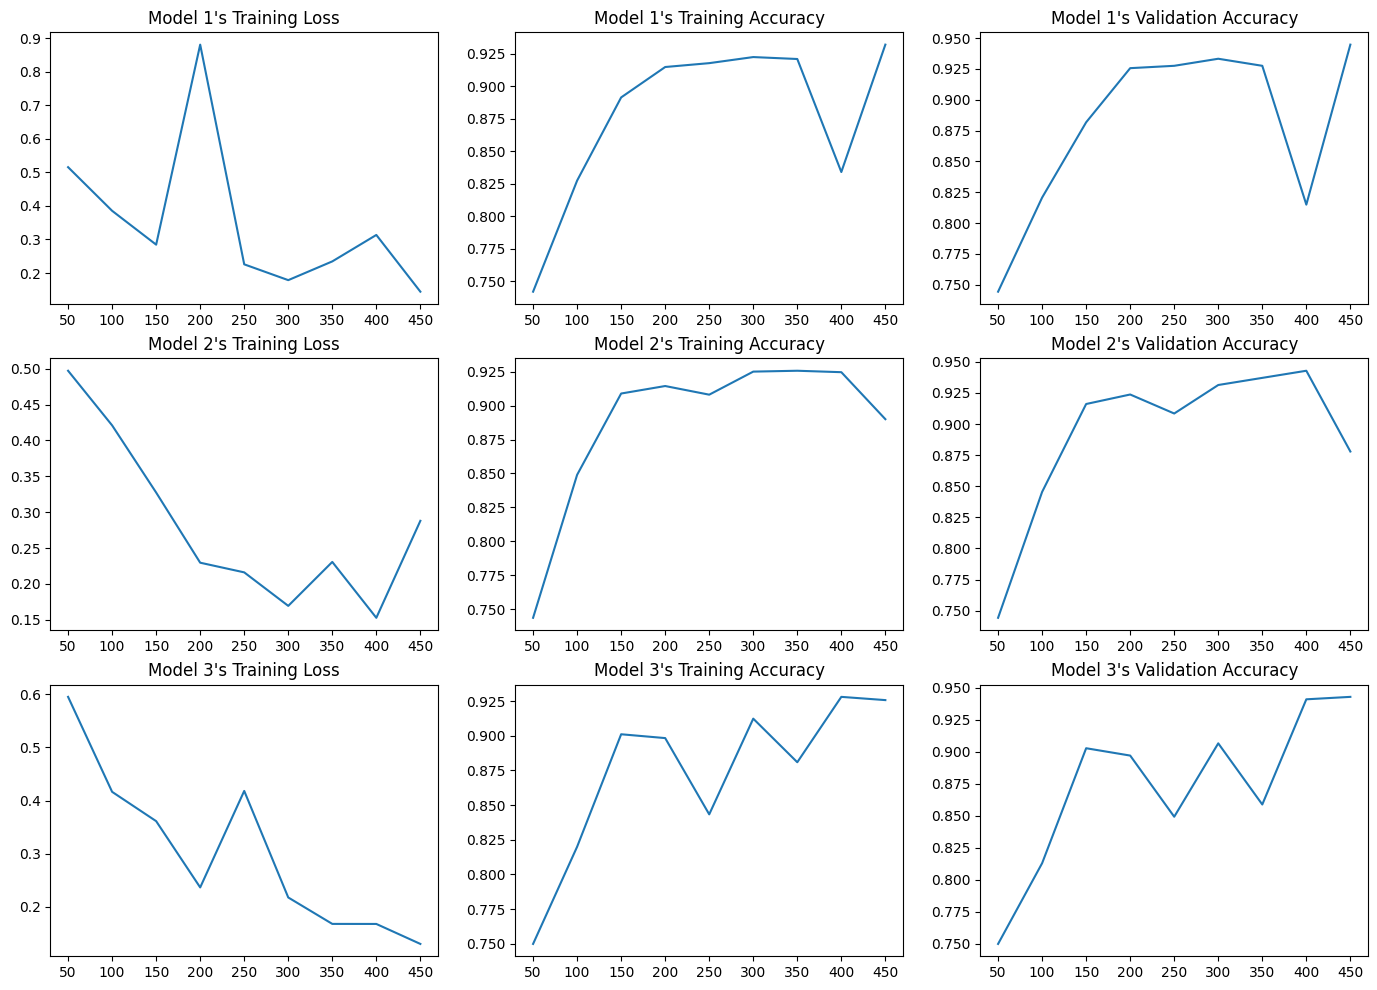

In [85]:
# Comparision of each metric

fig, axs = plt.subplots(3, 3, figsize=(17, 12))

metrics = [mlp_metrics_1, mlp_metrics_2, mlp_metrics_3]
labels = ["Training Loss", "Training Accuracy", "Validation Accuracy"]

for i in range(3):
  for j in range(3):

    axs[i, j].plot(metrics[i][0], metrics[i][j+1])
    axs[i, j].set_title(f'Model {i+1}\'s {labels[j]}')

plt.show()

